In [23]:
import torch
import torchvision
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
%matplotlib inline
import torchvision.transforms as transforms

from torch.utils.data import random_split
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F

In [63]:
dataset = MNIST(root='data/', download=True)       #images not yet converted in tensor form
test_dataset = MNIST(root='data/', train=False)

In [64]:
dataset = MNIST(root='data/' , train=True , transform=transforms.ToTensor())   #convert images to tensor
test_dataset = MNIST(root='data/', train=False , transform=transforms.ToTensor())

In [13]:
train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

In [16]:
batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

In [21]:
input_size = 28*28
num_class = 10


In [51]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size,num_class)
    
    def forward(self,xb):
        xb=xb.reshape(-1,784)
        out=self.linear(xb)
        return out
    
    def training_step(self,batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        return loss
    
    def validation_step(self,batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss':loss,'val_acc':acc}
    
    def validation_epoch_end(self,outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()     
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

In [52]:
for images, labels in train_loader:
    print(images.shape)
    outputs = model(images)
    print(outputs.shape)
    break


torch.Size([128, 1, 28, 28])
torch.Size([128, 10])


In [53]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [54]:
loss_fn = F.cross_entropy

In [55]:
loss = loss_fn(outputs, labels)
print(loss)

tensor(2.3568, grad_fn=<NllLossBackward>)


In [56]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [57]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [58]:
result0 = evaluate(model, val_loader)
result0

{'val_loss': 2.329793691635132, 'val_acc': 0.09493670612573624}

In [59]:
history = fit(25, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9564, val_acc: 0.6116
Epoch [1], val_loss: 1.6818, val_acc: 0.7339
Epoch [2], val_loss: 1.4766, val_acc: 0.7703
Epoch [3], val_loss: 1.3218, val_acc: 0.7921
Epoch [4], val_loss: 1.2030, val_acc: 0.8043
Epoch [5], val_loss: 1.1099, val_acc: 0.8125
Epoch [6], val_loss: 1.0354, val_acc: 0.8176
Epoch [7], val_loss: 0.9746, val_acc: 0.8233
Epoch [8], val_loss: 0.9241, val_acc: 0.8269
Epoch [9], val_loss: 0.8814, val_acc: 0.8319
Epoch [10], val_loss: 0.8449, val_acc: 0.8362
Epoch [11], val_loss: 0.8134, val_acc: 0.8388
Epoch [12], val_loss: 0.7858, val_acc: 0.8425
Epoch [13], val_loss: 0.7614, val_acc: 0.8449
Epoch [14], val_loss: 0.7397, val_acc: 0.8473
Epoch [15], val_loss: 0.7203, val_acc: 0.8497
Epoch [16], val_loss: 0.7027, val_acc: 0.8510
Epoch [17], val_loss: 0.6868, val_acc: 0.8520
Epoch [18], val_loss: 0.6723, val_acc: 0.8539
Epoch [19], val_loss: 0.6590, val_acc: 0.8551
Epoch [20], val_loss: 0.6468, val_acc: 0.8563
Epoch [21], val_loss: 0.6355, val_acc: 0.857

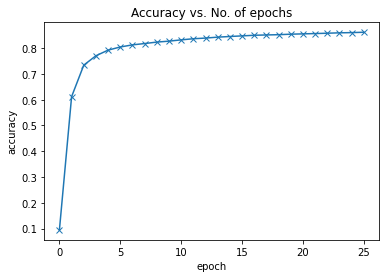

In [62]:
history_final=[result0]+history;

accuracies = [result['val_acc'] for result in history_final]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [65]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

Label: 0 , Predicted: 0


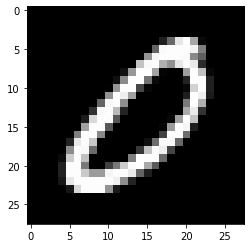

In [69]:
img, label = test_dataset[192]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [70]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_loss': 0.5863774418830872, 'val_acc': 0.86767578125}

In [71]:
torch.save(model.state_dict(), 'mnist-logistic.pth')

In [72]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0164, -0.0198,  0.0246,  ..., -0.0313,  0.0187, -0.0297],
                      [ 0.0341, -0.0241,  0.0272,  ...,  0.0229, -0.0182, -0.0250],
                      [ 0.0275, -0.0356,  0.0113,  ...,  0.0288,  0.0017, -0.0215],
                      ...,
                      [ 0.0083,  0.0177,  0.0192,  ...,  0.0234, -0.0155, -0.0178],
                      [-0.0238, -0.0160,  0.0135,  ..., -0.0002, -0.0309,  0.0131],
                      [ 0.0352, -0.0053, -0.0313,  ..., -0.0298,  0.0104, -0.0349]])),
             ('linear.bias',
              tensor([-0.0383,  0.0849, -0.0056, -0.0440,  0.0188,  0.0426,  0.0114,  0.0510,
                      -0.1069, -0.0059]))])